1. Używane biblioteki

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from bisect import bisect_left, bisect_right
from enum import Enum
from itertools import chain

Równomiernie rozprowadzone punkty

In [3]:
#return evenly distrubuted x arguments on [a, b]
def get_evenly_distributed(a, b, n = 100) -> list:
    
    length = abs(b - a)
    h = length / (n - 1)
    
    return [a + i * h for i in range(n - 1)] + [b]

Zera wielomianu Czebyszewa - Inaczej węzły Czebyszewa. Są często używane jako węzły w interpolacji wielomianowej,
ponieważ wynikowy wielomian interpolacyjny minimalizuje efekt Rungego, czyli duże oscylacje wielomianu interpolacyjnego przy krańcach przedziału.

Reference: https://pl.wikipedia.org/wiki/W%C4%99z%C5%82y_Czebyszewa

In [4]:
def get_chebyshev_nodes(a, b, n = 100) -> list:

    nodes = []

    for k in range(1, n + 1): #n + 1, because range is exclusive on the right side

        nodes.append( 0.5 * (a + b) + 0.5 * (b - a) *  math.cos( ( (2 * k - 1) / (2 * n) ) * math.pi ) )
    
    return nodes[::-1] #Flipping an array in order to it being consistent with input range

2. Liniowa funkcja sklejana

2.1 Funkcja kształtu

In [5]:
# x - argument, xs - lista x-ow, i - pozycja w liscie x-ow
def shape_function(x, xs, i):
    
    if i < 0 or i >= len(xs):
        return
    
    # dodatkowo i nie może być równe 0, bo wtedy wyjdziemy poza zakres, a w pythonie odczytamy ostatni element
    if i > 0:
        if x >= xs[i - 1] and x <= xs[i]:
            return (x - xs[i - 1]) / (xs[i] - xs[i - 1])
    
    # dodatkowo i nie moze byc rowne len(xs) -1, bo wtedy by bylo ostatnim elementem i nie mozna by bylo zrobic xs[i + 1]
    if i < len(xs) - 1:
        if x >= xs[i] and x <= xs[i + 1]:
            return (xs[i + 1] - x) / (xs[i + 1] - xs[i])
    
    return 0

2.2 Funkcja sklejana

In [6]:
def linear_spline(x, xs, ys) -> float:
    
    # checmy poznać wartość funkcji sklejanej dla danego x-a, czyli trzeba poznać jego pozycję w liście xs
    # do tego będę używać wyszukiwania binarnego, z tego powodu funkcja wymaga posortowanej listy xs
    #i = binary_search(xs, x)
    i = bisect_left(xs, x)
    
    # Wartośc funkcji sklejanej w punkcie x
    s = 0
    
    # Warunek sprawdza, czy bisect_left znalazł x w liście xs
    if i < len(xs):

        s += ys[i] * shape_function(x, xs, i)

        
        #To musi być wewnątrz ponieważ trzbea sobie zagwarantować, że x został faktycznie znaleziony przez bisect_left
        if i > 0:
            
            s += ys[i - 1] * shape_function(x, xs, i - 1)
            
    return s

3. Sześcienna funkcja sklejana

In [7]:
#Tak jak powyżej
def h(i, xs) -> float:
        return xs[i + 1] - xs[i]

In [8]:
def delta_1(i, xs, ys) -> float:
    return (ys[i + 1] - ys[i]) / (xs[i + 1] - xs[i]) 

In [9]:
def delta_2(i, xs, ys) -> float:
    return (delta_1(i + 1, xs, ys) - delta_1(i, xs, ys)) / (xs[i + 2] - xs[i])

In [10]:
def delta_3(i, xs, ys) -> float:
    return (delta_2(i + 1, xs, ys) - delta_2(i, xs, ys)) / (xs[i + 3] - xs[i]) 

In [11]:
#Funkcja przygotowuje dwie macierze narazie bez warunków brzegowych
def get_initial_matrix(xs, ys):
    
    n = len(xs)
    
    #Rzędów jest tyle ile sigm, czyli len(xs)
    A = np.zeros(shape=(n, n))
    C = np.zeros(shape=(n, 1))
    
    #Uzupełniam macieraze zgodnie ze wzorem powyżej, oprócz i = 0 oraz i = n, ponieważ tam idą warunku brzegowe
    #Należy zwrócić uwagę, że delty i h są przesunięte o 1 do tyłu ze względu na numerację tablic od 0
    for i in range(1, n - 1):
        A[i][i - 1] = h(i - 1, xs) 
        A[i][i] = 2 * (h(i - 1, xs) + h(i, xs))
        A[i][i + 1] = h(i, xs)
        
        C[i] = delta_1(i, xs, ys) - delta_1(i - 1, xs, ys)
        
    return A, C

Cubic spline boundary

In [12]:
def cubic_boundary(A, C, xs, ys):
    
    A[0][0] = -h(0, xs)
    A[0][1] = h(0, xs)
    
    A[-1][-2] = h(len(A) - 2, xs)
    A[-1][-1] = -h(len(A) - 2, xs)
    
    C[0] = (h(0, xs) ** 2) * delta_3(0, xs, ys)
    C[-1] = -(h(len(C) - 2, xs) ** 2) * delta_3(len(C) - 4, xs, ys)
    
    sigma = np.linalg.solve(A, C)
    
    return list(chain.from_iterable(sigma)) #np.linalg.solve zwraca lista = [[val1], [val2], [val3], ...], a ja chce list = [val1, val2, val3, ....]

Natural cubic spline boundary

In [13]:
def natural_cubic_boundary(A, C):
    
    #Ponieważ sigma_i = 1/6 * S_i''(x_i), skoro S_i'' = 0 to sigma tez = 0
    #Dzięki temu warunkowi wystarczy, że rozwiązać n - 2 równań, bo sigma(1) = sigma(n) = 0
    
    
    #ten kod choć poprawny generuje niemal niemożliwe do wykrycia problemy (~2 godziny debugowania na ślepo, dodatkowo problem nie występował
    #dla równoodległych węzłów, tylko dla węzłów Czbyszewa!)
    #A = A[1:-1, 1:-1]
    #C = C[1:-1]
    # [0, *np.linalg.solve(A, C), 0] 
    
    A[0][0] = 1
    A[0][1] = 0
    
    A[-1][-1] = 1
    A[-1][-2] = 0
    
    C[0] = 0
    C[-1] = 0
    
    
    sigma = np.linalg.solve(A, C)
    
    return list(chain.from_iterable(sigma)) #np.linalg.solve zwraca lista = [[val1], [val2], [val3], ...], a ja chce list = [val1, val2, val3, ....]

In [14]:
def search_range_idx(xs, x):
    
    l = 0
    r = len(xs) - 1

    while l <= r:
        m = (l + r) // 2
        if x >= xs[m]:
            l = m + 1
        else:
            r = m - 1

    return l - 1

In [15]:
# boundary_type:
# 0 - cubic_boundary
# 1 - natural_cubic_boundary

def cubic_spline(x, xs, ys, boundary_type) -> float:
        
        # tak jak w przypadku linear_spline trzeba poznać pozycję x-a w liście xs
        #i = min(bisect_right(xs, x) - 1, len(xs) - 2) 
        i = max(0, min(search_range_idx(xs, x), len(xs) - 2))
    
        #Tworzę obie macierze
        A, C = get_initial_matrix(xs, ys)
        sigma = []
        
        if(boundary_type == 0): sigma = cubic_boundary(A, C, xs, ys)
        elif(boundary_type == 1): sigma = natural_cubic_boundary(A, C)
        
        # zgodnie z powyższym wzorem

        b = ( (ys[i + 1] - ys[i]) / h(i, xs) ) - h(i, xs) * (sigma[i + 1] + 2 * sigma[i])
        c = 3 * sigma[i]
        d = (sigma[i + 1] - sigma[i]) / h(i, xs)

        
        return ys[i] + b * (x - xs[i]) + c * ((x - xs[i]) ** 2 ) + d * ((x - xs[i]) ** 3)

4. Kwadratowa funkcja sklejana

Natural spline boundary

In [16]:
class Natural_quadratic_boundary():
    
    @staticmethod
    def get_v(i, xs, ys):
        return (ys[i] - ys[i - 1]) / (xs[i] - xs[i - 1])
        
    @staticmethod
    def get_b(i, xs, ys):
        
        if i == 0: # warunek brzegowy
            return 0
        
        return 2 * Natural_quadratic_boundary.get_v(i, xs, ys) - Natural_quadratic_boundary.get_b(i - 1, xs, ys)
    
    @staticmethod
    def get_c(i, xs, ys):
        return ((Natural_quadratic_boundary.get_b(i + 1, xs, ys) - Natural_quadratic_boundary.get_b(i, xs, ys)) /
           (2 * (xs[i + 1] - xs[i])))

Clamped spline boundary

In [17]:
class Clamped_quadratic_boundary():
    
    @staticmethod
    def get_v(i, xs, ys):
        return (ys[i] - ys[i - 1]) / (xs[i] - xs[i - 1])
        
    @staticmethod
    def get_b(i, xs, ys):
        
        if i == 0: # warunek brzegowy
            return Clamped_quadratic_boundary.get_v(1, xs, ys)
        
        return 2 * Clamped_quadratic_boundary.get_v(i, xs, ys) - Clamped_quadratic_boundary.get_b(i - 1, xs, ys)
    
    @staticmethod
    def get_c(i, xs, ys):
        return ((Clamped_quadratic_boundary.get_b(i + 1, xs, ys) - Clamped_quadratic_boundary.get_b(i, xs, ys)) / 
               (2 * (xs[i + 1] - xs[i])))

In [18]:
def search_range_idx(xs, x):
    
    l = 0
    r = len(xs) - 1

    while l <= r:
        m = (l + r) // 2
        if x >= xs[m]:
            l = m + 1
        else:
            r = m - 1

    return l - 1

In [19]:
def quadratic_spline(x, xs, ys, boundary):
    
    #i = min(bisect_right(xs, x) - 1, len(xs) - 2) 
    i = max(0, min(search_range_idx(xs, x), len(xs) - 2))
    b = boundary.get_b(i, xs, ys)
    c = boundary.get_c(i, xs, ys)
    
    return ys[i] + b * (x - xs[i]) +  c * ((x - xs[i]) ** 2)

5. Punkty testowe

In [20]:
# Zwraca n równomiernie rozprowadzonych punktów w przedziale [a, b]
def get_evenly_distributed(a, b, n = 100):
    
    length = abs(b - a)
    h = length / (n - 1)
    
    return [a + i * h for i in range(n - 1)] + [b]

6. Zadana funkcja

In [21]:
def f(x):
    return 30 + (x**2 / 1.5) - 30 * math.cos(1.5 * x)

f_range_a = -4 * math.pi
f_range_b = 4 * math.pi

7. Analiza

In [22]:
def plot_function(func, range_a, range_b, func_x = None):
    
    if func_x == None:
        func_x = np.linspace(range_a, range_b, 10000)
        
    func_y = [func(func_x[i]) for i in range(len(func_x))]

    plt.plot(func_x, func_y, label = "Zadana funkcja", color = 'blue')

    plt.legend()
    plt.grid(True)
    plt.savefig("zadana_funkcja.png")

In [23]:
class Interpolation(Enum):
    LINEAR = "Linear spline"
    CUBIC = "Cubic spline with cubic boundary"
    CUBIC_NATURAL = "Cubic spline with natural boundary"
    QUADRATIC_NATURAL = "Quadratic spline with natural boundary"
    QUADRATIC_CLAMPED = "Quadratic spline with clamped boundary"

In [26]:
def interpolate(spline_type, point_generation_function, n, test_points_count, nodes_plot_label = 'Węzły'):
    
    xs = point_generation_function(f_range_a, f_range_b, n)
    ys = [ f(xs[i]) for i in range(len(xs))]
    
    check_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
    check_y = []

    for i in range(len(check_x)):

        if(spline_type == Interpolation.LINEAR): 
            check_y.append(linear_spline(check_x[i], xs, ys))
        elif(spline_type == Interpolation.CUBIC): 
            check_y.append(cubic_spline(check_x[i], xs, ys, 0))
        elif(spline_type == Interpolation.CUBIC_NATURAL): 
            check_y.append(cubic_spline(check_x[i], xs, ys, 1))
        elif(spline_type == Interpolation.QUADRATIC_NATURAL): 
            check_y.append(quadratic_spline(check_x[i], xs, ys, Natural_quadratic_boundary))
        elif(spline_type == Interpolation.QUADRATIC_CLAMPED): 
            check_y.append(quadratic_spline(check_x[i], xs, ys, Clamped_quadratic_boundary))
    
    plot_function(f, f_range_a, f_range_b)
    
    plt.plot(check_x, check_y, color = 'red', label = "Funkcja interpolująca")
    plt.scatter(xs, ys, color = 'black', label=nodes_plot_label)
    
    plt.title(spline_type.value)
    plt.legend()
    plt.grid(True)
    plt.savefig("interpolacja_spline.png")
    plt.show()

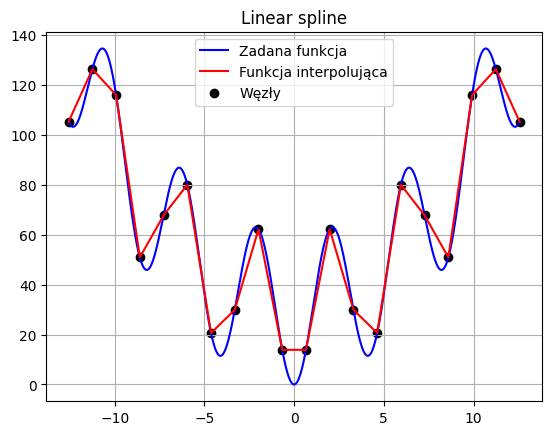

In [25]:
interpolate(Interpolation.LINEAR, get_evenly_distributed, 20, 1000)

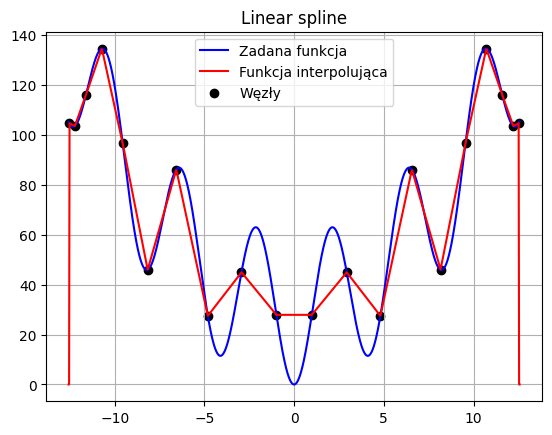

In [73]:
interpolate(Interpolation.LINEAR, get_chebyshev_nodes, 20, 1000)

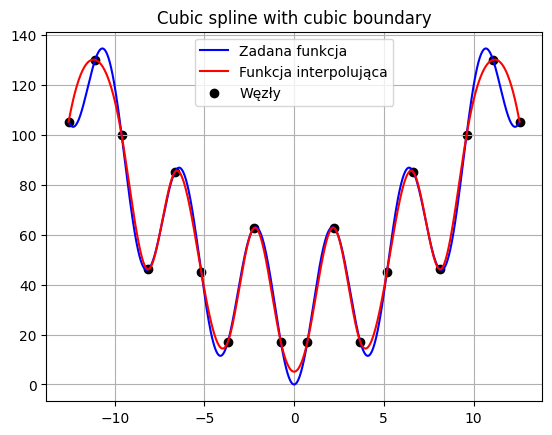

In [27]:
interpolate(Interpolation.CUBIC, get_evenly_distributed, 18, 1000)

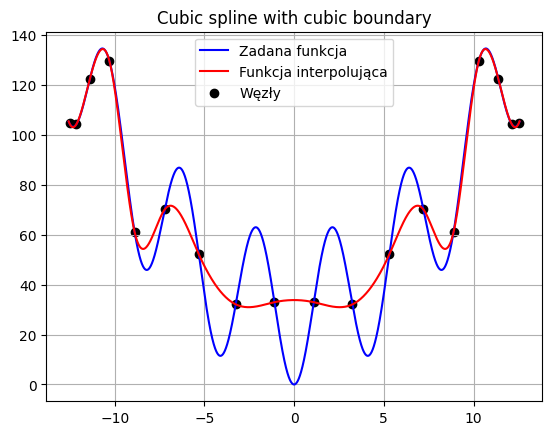

In [28]:
interpolate(Interpolation.CUBIC, get_chebyshev_nodes, 18, 1000)

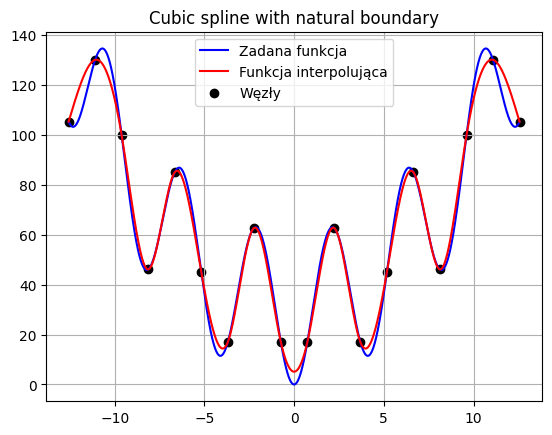

In [29]:
interpolate(Interpolation.CUBIC_NATURAL, get_evenly_distributed, 18, 1000)

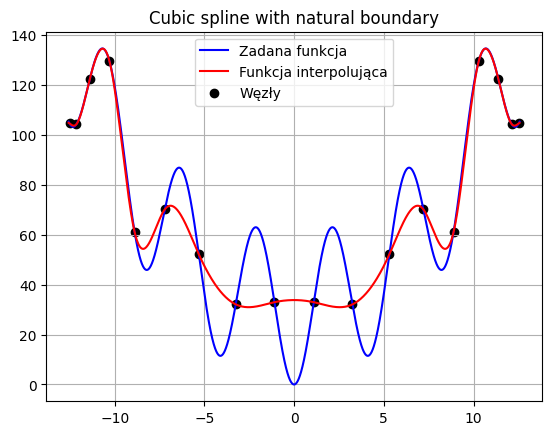

In [30]:
interpolate(Interpolation.CUBIC_NATURAL, get_chebyshev_nodes, 18, 1000)

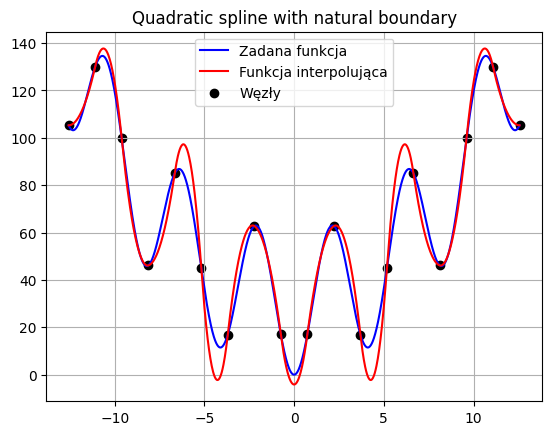

In [31]:
interpolate(Interpolation.QUADRATIC_NATURAL, get_evenly_distributed, 18, 1000)

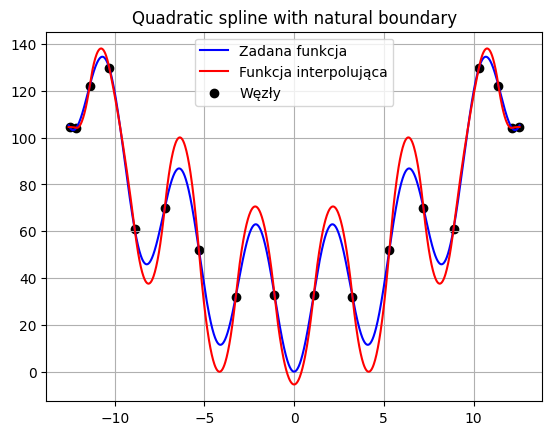

In [32]:
interpolate(Interpolation.QUADRATIC_NATURAL, get_chebyshev_nodes, 18, 1000)

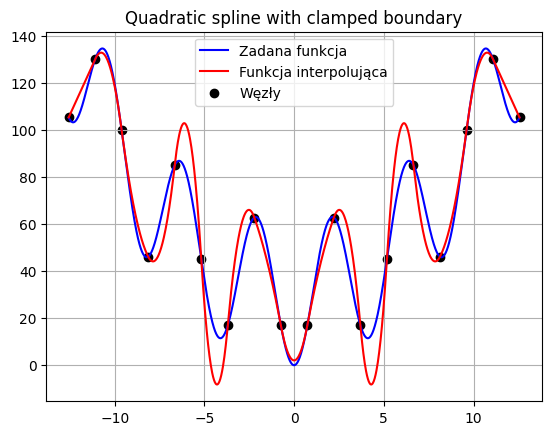

In [33]:
interpolate(Interpolation.QUADRATIC_CLAMPED, get_evenly_distributed, 18, 1000)

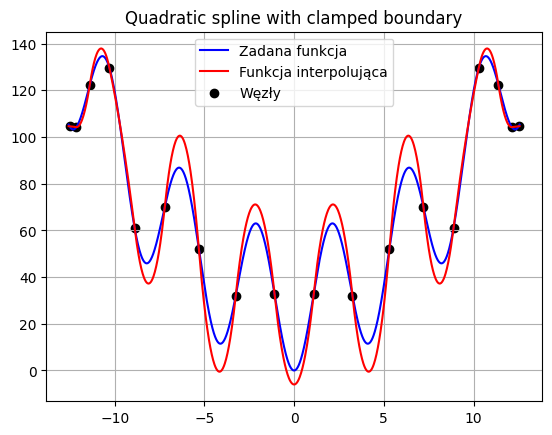

In [34]:
interpolate(Interpolation.QUADRATIC_CLAMPED, get_chebyshev_nodes, 18, 1000)

Różnica między wielomianem interpolowanym, a wielomienaem interpolującym

1. Maksimum

max na x należącym do [-4pi, 4pi] z |F(x) - Pn(x)|

2. Błąd średniokwadratowy

!/N suma (F(x) - Pn(x))^2

1. Maksumum

1.1 Różnica maksimum dla interpolacji lagrange'a z równomiernie wygenerowanymi węzłami

In [35]:
def interpolation_maximum_difference(spline_type, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    #Wartości n do przetestowania od 3 do 30
    N = [i for i in range(interpolation_range_a, intepolation_range_b)]

    for i in range(len(N)):

        maksimum = float('-inf')

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])
        ys = [f(xs[j]) for j in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            if(spline_type == Interpolation.LINEAR): 
                temp = abs(f(test_x[j]) - (linear_spline(test_x[j], xs, ys)))
            elif(spline_type == Interpolation.CUBIC):
                temp = abs(f(test_x[j]) - (cubic_spline(test_x[j], xs, ys, 0)))
            elif(spline_type == Interpolation.CUBIC_NATURAL):
                temp = abs(f(test_x[j]) - (cubic_spline(test_x[j], xs, ys, 1)))
            elif(spline_type == Interpolation.QUADRATIC_NATURAL):
                temp = abs(f(test_x[j]) - (quadratic_spline(test_x[j], xs, ys, Natural_quadratic_boundary)))
            elif(spline_type == Interpolation.QUADRATIC_CLAMPED):
                temp = abs(f(test_x[j]) - (quadratic_spline(test_x[j], xs, ys, Clamped_quadratic_boundary)))
            
            maksimum = temp if temp > maksimum else maksimum
    
        print(f"{maksimum}")

Węzły 3-30

In [74]:
interpolation_maximum_difference(Interpolation.CUBIC, get_evenly_distributed, 1000, 4, 30 + 1)

59.99866494451233
68.1601496979736
59.664759556692786
59.99866494451234
59.945925807606194
45.65915906066198
56.34418509775077
48.240939087494176
40.20626570558051
37.62830785568089
37.06562854691653
32.39268179737245
26.475928787139466
20.796159950038685
15.953058802548142
12.037603820482161
8.97169614127715
6.614480096480662
4.821253237932794
3.466388031606087
2.4513198634147955
1.6910554468999237
1.1260403799547873
0.7101260346700968
0.4657888912827417
0.3903834403333235
0.3468209840681027


In [39]:
interpolation_maximum_difference(Interpolation.CUBIC, get_chebyshev_nodes, 1000, 4, 30 + 1)

50.253888395184106
55.61517717254382
54.22394394985672
53.65906643030294
61.517514722721785
69.551329214991
62.42362348371704
57.840203241225886
61.34364331331395
57.3329605179207
59.98195180060908
39.492511007631364
48.21256561828126
12.396070556220522
33.810371116396176
7.605344541088428
22.07010888381024
10.152879085478048
14.053955926488177
8.312912547458232
8.991071515831916
6.015601559225068
5.871902296251086
4.361019183524263
3.941919623036013
3.0432637393116195
2.7244653865143187


In [40]:
interpolation_maximum_difference(Interpolation.CUBIC_NATURAL, get_evenly_distributed, 1000, 3, 30 + 1)

58.78921498774631
61.75307219867342
57.83549493717511
60.28832080811033
60.27934108371761
59.85715410863607
45.87041646312313
56.333549724859324
48.90802911706107
40.2498515456147
18.42608989387209
21.1968785532145
18.29691988229702
16.28635312691563
14.155988538836127
12.218625525116906
10.55681835866288
9.164721687295525
8.005319935532796
7.0413021655432
6.237213439145833
5.562429821242787
4.9915471602173795
4.503842251744544
4.082489889644691
3.7212704213928447
3.405956619618138
3.128541584872451


In [41]:
interpolation_maximum_difference(Interpolation.CUBIC_NATURAL, get_chebyshev_nodes, 1000, 3, 30 + 1)

58.880476315931986
52.63777718377493
55.258305057052205
52.799511296681175
55.10797086507257
62.12992262124167
71.0036946026684
62.88949282406608
57.89489666040991
61.34637492533847
57.366067856420074
59.99019640361442
39.47744948505208
48.21051637039876
12.399300290534853
33.81077203695708
7.612204613376136
22.070029563498384
10.152449326244007
14.053971986236833
8.313002177474743
8.99106818473544
6.015596163635934
5.871903004158266
4.36102032218237
3.9419194693177952
3.0432634896192994
2.7244654205118213


In [42]:
interpolation_maximum_difference(Interpolation.QUADRATIC_CLAMPED, get_evenly_distributed, 1000, 3, 30 + 1)

86.31758364242194
68.8292397344354
114.54241657251907
70.06394245795715
62.92296580280272
55.185715327516604
56.510916269397654
80.0415161756039
97.79385869877538
121.95261729632588
329.4517341562276
80.83368198766244
55.539052840966875
37.204071594084326
27.099530687157596
22.084626135541704
19.073494705885935
16.427942743821546
14.233530059714113
12.81279148507518
11.512101568446013
10.42020109485684
9.047892485885498
8.69895615486989
8.017861418203921
7.408623617352529
6.859592798013125
6.396216726152915


In [43]:
interpolation_maximum_difference(Interpolation.QUADRATIC_CLAMPED, get_chebyshev_nodes, 1000, 3, 30 + 1)

96.47903367932452
60.79443388129573
69.52484028265212
51.07222436185192
62.11081762141731
108.61482717759279
135.31106554811322
135.09769936394693
110.59615032526929
68.15739987551812
140.98947013513947
203.16896210732833
166.05681012403548
90.28783829207384
200.22522124803294
13.925785309818238
151.88606957133283
52.30762869671244
68.69134888054543
33.86287365688838
36.32968371688843
25.934304171489945
14.399656179786959
11.154783311154823
11.749741797526987
10.369656146987644
8.021971874988296
5.728661142388898


In [44]:
interpolation_maximum_difference(Interpolation.QUADRATIC_NATURAL, get_evenly_distributed, 1000, 3, 30 + 1)

112.63650234033153
86.8108360734261
110.244955723321
81.72540263252412
77.54447009425463
59.4879080150764
60.369839060010975
79.18919328637627
93.70115399113762
127.947609954271
336.408265565484
88.13930495216985
48.26472076881787
30.188519149073134
20.494676914433157
15.925699378493686
13.34768867500128
11.16633887211394
9.432297505790132
8.420238138556698
7.512976000823571
6.7885078311176805
5.796296729667915
5.713794690241812
5.31567925057746
4.967461177360006
4.656192520329583
4.407796930689869


In [45]:
interpolation_maximum_difference(Interpolation.QUADRATIC_NATURAL, get_chebyshev_nodes, 1000, 3, 30 + 1)

120.31556390206896
86.5417840044816
60.293158126111365
68.80397280342888
65.34519065916588
127.9173321328393
156.98222341127402
153.41700465157427
125.73320829268832
61.53564893315398
133.3467388120025
197.6632104832278
162.83235502923247
92.0405549146071
200.65358406168968
13.48805138099037
152.94645419486432
54.164622962493056
66.54353319440384
31.202200024999055
39.08859288969526
29.064416200230802
17.59131548520655
12.07980577109739
15.165074122916927
13.892898246112988
11.527269679089557
9.067399220990652


Węzły 31-70

In [48]:
interpolation_maximum_difference(Interpolation.CUBIC, get_evenly_distributed, 1000, 31, 70 + 1)

0.30595340054688336
0.2687648439259078
0.31733904393503565
0.3492490276050546
0.36824310365058466
0.377426451382334
0.379219920158846
0.37550909190515824
0.36776073289644273
0.35711375952602964
0.34445032392699204
0.3306719531240958
0.31683990507832505
0.30255273847529907
0.2881011568667162
0.27370475689822626
0.25952733216260526
0.24568894336037772
0.23277665916369017
0.2206113875498943
0.20890346852402786
0.19767734262156011
0.18694574263670916
0.17671241779223124
0.1669742914093746
0.15772316807438358
0.14927395090796836
0.1414718524844858
0.13406688799474864
0.127044331192522
0.12038865784347763
0.11408391660313555
0.1081140158825491
0.10246294363388131
0.09711493363896295
0.09205458920682474
0.08726697303917774
0.08304054624872492
0.07904602980873676
0.07525756638518999


In [49]:
interpolation_maximum_difference(Interpolation.CUBIC, get_chebyshev_nodes, 1000, 31, 70 + 1)

2.090698624900149
1.9363760775888934
1.4297924088228555
1.411943075933224
0.978285837304206
1.053437554387663
0.6711265185386424
0.8021285365789858
0.5158153378221897
0.621879437905945
0.44974733858807525
0.48989393789732655
0.38538659178021817
0.39143326997489064
0.3232002358975876
0.31674285505501826
0.26797623253513336
0.25922450345629244
0.2206857144597123
0.21432427996730172
0.18050386331719892
0.17884042937902137
0.1472373990052276
0.15048332057467365
0.11995889008024108
0.12758988557964016
0.10274147281410961
0.10893475010727861
0.0886568810544004
0.09360307837532807
0.07853619199227779
0.08090354161176415
0.06982232533470523
0.07030782816271874
0.06168105060642404
0.06140799688623097
0.05430155835100692
0.0538860086932286
0.047440549780723984
0.04749168783271119


In [50]:
interpolation_maximum_difference(Interpolation.CUBIC_NATURAL, get_evenly_distributed, 1000, 31, 70 + 1)

2.8863604582974034
2.670208605984783
2.4785455981752307
2.3082021957596908
2.1516688335527476
2.015743414146158
1.890541951697145
1.7744600337198904
1.6729223277255727
1.5791570952365532
1.4915649881531294
1.4104545022871662
1.3393438829447462
1.272486059870559
1.2095343397678562
1.150179031829282
1.0965393067967426
1.0479580603819443
1.0019155530493293
0.9582306731468435
0.916739334919626
0.877292515655526
0.8419883277593243
0.809587043379409
0.7786541662296145
0.7490986973167111
0.7208371027332703
0.6937925582406024
0.6678942839800328
0.6430769570243058
0.6216283182241682
0.601254922511032
0.5816666148079719
0.5628220010153768
0.5446825851477541
0.5272125178910159
0.5103783710194989
0.49414893461575105
0.4784950344421901
0.4633893671607012


In [51]:
interpolation_maximum_difference(Interpolation.CUBIC_NATURAL, get_chebyshev_nodes, 1000, 31, 70 + 1)

2.0906986794475557
1.936376069952352
1.4297923966626271
1.4119430776711923
0.9782858400863219
1.0534375539876788
0.6711265179058827
0.8021285366719351
0.5158153378572727
0.621879437884164
0.4497473387320028
0.4898939379024673
0.38538659174652423
0.3914332699736703
0.32320023590538227
0.31674285505531047
0.267976232533222
0.25922450345622156
0.22068571446015284
0.2143242799673177
0.18050386331708523
0.17884042937901692
0.14723739900526311
0.15048332057467514
0.11995889008023397
0.12758988557964027
0.10274147281411317
0.10893475010727861
0.0886568810544004
0.09360307837532807
0.07853619199227069
0.08090354161176415
0.06982232533470523
0.07030782816271874
0.061681050606409826
0.06140799688623097
0.05430155835100692
0.0538860086932286
0.047440549780723984
0.04749168783271119


In [75]:
interpolation_maximum_difference(Interpolation.QUADRATIC_CLAMPED, get_evenly_distributed, 1000, 31, 70 + 1)

5.974316339948388
5.5866559918384695
5.237112239969264
4.925160214039181
4.642529427184087
4.379655882033148
4.108224692642764
3.88244165228042
3.717236798769079
3.525714651107582
3.355342587601214
3.193837463075784
3.0454595412039396
2.9034241449043066
2.7762815198536828
2.6509223550154957
2.541363725668205
2.4327650837189765
2.330588840252318
2.242518334373102
2.1537258521409726
2.068859512833825
1.99244785593244
1.9182646924319329
1.8474883788016356
1.7806966498520467
1.7196122234814304
1.6589577423131345
1.6036345329019746
1.5498157270662354
1.4978927981283534
1.4467677154031477
1.403491592404336
1.3595847898905973
1.3183669619865839
1.2768850069648607
1.2390733645256375
1.2036426548058472
1.1687801534348523
1.1327529057806913


In [76]:
interpolation_maximum_difference(Interpolation.QUADRATIC_CLAMPED, get_chebyshev_nodes, 1000, 31, 70 + 1)

5.8436464849230845
5.3356418289542304
4.329361236441741
3.6776214243246415
3.2905345727671858
3.1789968907539983
2.554612546853484
2.4198119283008452
2.0902637492683347
2.057649904653978
1.750549752276946
1.635799956007368
1.478406259153168
1.4091721032561368
1.258493951801146
1.1547716181302192
1.078341227400939
1.006608706375384
0.9295685892078689
0.8431877584066143
0.8060109008282463
0.7432501448071172
0.7036134017897488
0.6331779566381215
0.6170650042452381
0.5637466966210365
0.5430823696440754
0.4939537856185723
0.4805663004765277
0.4372622616689723
0.4272296728619711
0.4008484644050121
0.3816756255592324
0.3486802059069376
0.34335717860258086
0.32807114029615114
0.3095732856602069
0.28912868180518103
0.27918104262504784
0.2703546964180532


In [77]:
interpolation_maximum_difference(Interpolation.QUADRATIC_NATURAL, get_evenly_distributed, 1000, 31, 70 + 1)

4.184566975699056
3.979439262593246
3.7948196365380795
3.635684585638707
3.4911780637999357
3.355693988421109
3.2034169882560235
3.0842343100331675
3.0171109334834654
2.917293065585186
2.8298549258153827
2.7456143546118046
2.6686856683897844
2.5923169562897925
2.5260809447961847
2.457269378678511
2.399439228128145
2.3391346371834736
2.2814961362043675
2.2347773268091373
2.1843869698723353
2.135167307959648
2.0918768618755053
2.0484093643590313
2.006154399587537
1.9659057103377222
1.92970101221783
1.8920000072729408
1.8580799861058637
1.8241240341596292
1.790743858404571
1.7564524202621214
1.7296538408301885
1.7008675171196277
1.6734925227135022
1.6446281983887872
1.6192746476385338
1.5952079259161849
1.5707949181238945
1.5444294370995095


In [78]:
interpolation_maximum_difference(Interpolation.QUADRATIC_NATURAL, get_chebyshev_nodes, 1000, 31, 70 + 1)

9.349107393888758
8.901515713211722
7.775733863431583
7.110222259344738
6.644226032563566
6.6447776983217555
5.809065949133782
5.7640346586364615
5.286519749096815
5.368015667471077
4.885265828435912
4.7922330741896175
4.5545562593744435
4.547303637015348
4.269406152200837
4.102830771438704
4.011946486475644
3.9729414145921638
3.7839562116143384
3.5993034178607957
3.5826516410489058
3.5457686171409595
3.4076226895963417
3.22728499996375
3.251291940652851
3.2134055490320614
3.1129690225738873
2.961657691554322
2.9818537688587465
2.9457970084557337
2.8692568008195494
2.7563413154750087
2.758633713967181
2.7245322537179435
2.664502574582814
2.578032584070975
2.5711884907863185
2.537715844589459
2.488443888072559
2.4171813794606436


In [52]:
def interpolation_maximum_difference(spline_type, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    #Wartości n do przetestowania od 3 do 30
    N = [i for i in range(interpolation_range_a, intepolation_range_b)]

    for i in range(len(N)):

        maksimum = float('-inf')

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])
        ys = [f(xs[j]) for j in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            if(spline_type == Interpolation.LINEAR): 
                temp = abs(f(test_x[j]) - (linear_spline(test_x[j], xs, ys)))
            elif(spline_type == Interpolation.CUBIC):
                temp = abs(f(test_x[j]) - (cubic_spline(test_x[j], xs, ys, 0)))
            elif(spline_type == Interpolation.CUBIC_NATURAL):
                temp = abs(f(test_x[j]) - (cubic_spline(test_x[j], xs, ys, 1)))
            elif(spline_type == Interpolation.QUADRATIC_NATURAL):
                temp = abs(f(test_x[j]) - (quadratic_spline(test_x[j], xs, ys, Natural_quadratic_boundary)))
            elif(spline_type == Interpolation.QUADRATIC_CLAMPED):
                temp = abs(f(test_x[j]) - (quadratic_spline(test_x[j], xs, ys, Clamped_quadratic_boundary)))
            
            maksimum = temp if temp > maksimum else maksimum
    
        print(f"{maksimum}")

Błąd średniokwadratowy

In [53]:
def interpolation_mean_difference(spline_type, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    N = [i for i in range(interpolation_range_a, intepolation_range_b)]

    for i in range(len(N)):

        suma = 0

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])
        ys = [ f(xs[j]) for j in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            if(spline_type == Interpolation.LINEAR): 
                suma += (f(test_x[j]) - linear_spline(test_x[j], xs, ys)) ** 2
            elif(spline_type == Interpolation.CUBIC):
                suma += (f(test_x[j]) - cubic_spline(test_x[j], xs, ys, 0)) ** 2
            elif(spline_type == Interpolation.CUBIC_NATURAL):
                suma += (f(test_x[j]) - cubic_spline(test_x[j], xs, ys, 1)) ** 2
            elif(spline_type == Interpolation.QUADRATIC_NATURAL):
                suma += (f(test_x[j]) - quadratic_spline(test_x[j], xs, ys, Natural_quadratic_boundary)) ** 2
            elif(spline_type == Interpolation.QUADRATIC_CLAMPED):
                suma += (f(test_x[j]) - quadratic_spline(test_x[j], xs, ys, Clamped_quadratic_boundary)) ** 2

        print(f"{suma / test_points_count}")

In [56]:
interpolation_mean_difference(Interpolation.CUBIC, get_evenly_distributed, 1000, 4, 30 + 1)

1348.6499999999987
1000.8102238593121
899.1928375214778
1348.6499999999992
901.7964729376519
862.7347842629154
711.5355606938817
548.4759269157731
442.8418712205082
121.39546256929171
238.7925268695953
146.63700033381963
83.5168177118628
45.614556937988795
24.38050386314467
12.895649423488445
6.790100674208618
3.570323461971067
1.8782854315890805
0.9903799094963237
0.5248071416467148
0.28087585394277054
0.1531891208886272
0.08638709477889739
0.05139003831923363
0.03293583042339148
0.023034112155834743


In [57]:
interpolation_mean_difference(Interpolation.CUBIC, get_chebyshev_nodes, 1000, 4, 30 + 1)

694.429786959624
695.6712170478297
712.1007910499047
734.1559988029263
899.6366952166493
1051.03069766237
776.1207931989949
653.2786783860892
697.4020813523057
606.5758001489294
351.0916146395507
339.2708751178059
368.6744236153962
28.84592746086184
226.9396807696166
9.950086605954912
75.6280692594695
18.084751997221762
21.711895566460054
10.44345603025987
7.497186466454354
4.617273948359824
3.0587489949217344
2.0200781554273184
1.3624625428364534
0.9321563479840387
0.6476800782687138


In [58]:
interpolation_mean_difference(Interpolation.CUBIC_NATURAL, get_evenly_distributed, 1000, 3, 30 + 1)

1103.205421829149
1257.0870002127251
864.3805726293415
835.2161858507393
1334.226331551487
872.8503721824703
823.0356948777942
718.848648963285
564.7927078123988
397.36556414000165
28.7094389473071
150.13431099522356
85.75390915716787
48.91306557652378
28.520161792955868
17.199627551900583
10.769735773206822
6.998404798076881
4.707454161274435
3.266686955654672
2.3305232649735115
1.7037356083445676
1.2725561785545414
0.9686341447491124
0.7496957732476354
0.5888768623315128
0.4686721876945936
0.37740904557215166


In [59]:
interpolation_mean_difference(Interpolation.CUBIC_NATURAL, get_chebyshev_nodes, 1000, 3, 30 + 1)

861.0254462150119
689.2863880028574
699.6042383733716
700.5371482775523
763.1104836614409
934.54804747973
1069.0431693942926
767.2058447692367
642.0989462375658
696.7307102876422
608.4193119744403
350.48646295090526
337.9103279735918
368.107427540944
28.85252026322521
227.0415096069219
9.99774115961889
75.6382520808322
18.085275163410206
21.71201415365601
10.444007908973147
7.497747138960306
4.617686765595582
3.059030530180398
2.0202709398438814
1.3625971853848564
0.9322519693430412
0.647748874351942


In [79]:
interpolation_mean_difference(Interpolation.QUADRATIC_CLAMPED, get_evenly_distributed, 1000, 3, 30 + 1)

1717.7135641092575
1253.903289844549
2054.1490685232707
849.115443338437
1353.2063402972788
874.2026267785934
1007.9952027029418
1052.800869675661
1900.2482205188514
3643.627088176386
20111.970018862332
1622.4316356108166
575.297029252171
180.19243849582423
157.22647446780041
94.68189572817113
88.29490194290545
65.52572142970033
60.07009150686591
48.21400800924396
43.58355639169856
36.30836310058003
32.60315217594485
27.759390872217008
24.878693631294112
21.50028442231719
19.2838474775457
16.854168934523162


In [80]:
interpolation_mean_difference(Interpolation.QUADRATIC_CLAMPED, get_chebyshev_nodes, 1000, 3, 30 + 1)

1519.1427271263162
789.6686080667259
836.3864712963478
731.2072549700159
824.4381836943692
1863.4741447884721
3052.3848972483866
3289.6378534604582
2020.8281032946986
892.3796313495421
3631.093993532666
6842.504080109295
5402.042801519706
1194.1299378161173
8953.581178194387
51.55111732518758
4635.486560441669
531.9000028338397
780.4697962567742
149.08574724458293
169.3854605762231
67.97723174850445
30.189868392787247
17.49535452844326
13.372798810559345
9.095648373876985
6.151553913808255
4.486358577801519


In [81]:
interpolation_mean_difference(Interpolation.QUADRATIC_NATURAL, get_evenly_distributed, 1000, 3, 30 + 1)

2824.904256437032
1501.8185380724549
1872.0896014021257
909.542442121523
1512.6782507020514
890.7119553068418
1055.703126120748
1054.8440821288439
1845.4093723748194
4119.1303343047575
21355.74596592308
2012.7686267882482
488.80864710325807
139.53436164136252
87.2533233071519
42.62543555817923
35.13630849859435
22.814896947161728
20.687969178856417
15.70917097309951
14.665698837098923
12.116327260359666
11.406418191731595
9.879927647930204
9.325936896610498
8.310504121308938
7.855707213016961
7.129883223890038


In [82]:
interpolation_mean_difference(Interpolation.QUADRATIC_NATURAL, get_chebyshev_nodes, 1000, 3, 30 + 1)

3132.4381691285876
1506.4393150916128
758.9174775056587
1000.4815256074803
855.4432767614799
2757.2178747450057
4416.735177034979
4553.096227805991
2721.4214373048767
727.6595148334504
3125.9622100956894
6358.851315117364
5152.52754616543
1252.2699457478273
8999.570065457541
47.870284453868805
4720.6958127210855
578.0821837950668
733.5403632893904
129.56930070335144
199.26581303346393
89.79480779199619
35.45701607047999
24.139709360994253
23.7236053403874
18.88993204018693
14.840658413558737
12.842385701383462


Węzły 31-70

In [83]:
interpolation_mean_difference(Interpolation.CUBIC, get_evenly_distributed, 1000, 31, 70 + 1)

0.01752145279796641
0.014245267541694313
0.012105497197846352
0.01054915970077241
0.009304436203728462
0.008241525514550964
0.007300506981201259
0.0064544961966299915
0.005691257515649921
0.005004360221868352
0.004389174721842526
0.0038412549368224574
0.0033558402644588794
0.0029278397888062246
0.0025519881476044858
0.0022230326947951223
0.0019358929887056265
0.0016857768984343071
0.0014682530384873696
0.0012792870753556306
0.001115251595834231
0.0009729167286242632
0.0008494287968028319
0.0007422819686656681
0.0006492864437826516
0.0005685359501450352
0.0004983759347956077
0.000437373476492263
0.0003842898533757876
0.00033805547164873713
0.0002977475000379977
0.0002625702652688137
0.00023183774608603625
0.00020495863355405797
0.00018142296942447674
0.00016079099782729278
0.00014268315014942835
0.00012677176666942076
0.00011277362856226444
0.00010044391038805825


In [84]:
interpolation_mean_difference(Interpolation.CUBIC, get_chebyshev_nodes, 1000, 31, 70 + 1)

0.4565753968918177
0.3263361971555463
0.23631261663391825
0.17324122354046792
0.12848109312938738
0.0963264992885931
0.07295962246693237
0.055792953970508194
0.043051090707595864
0.03350139923694607
0.02627839109656084
0.020767814699762025
0.016529253035349807
0.013243845320247876
0.010678599519945927
0.00866176614310726
0.007065679856595963
0.005794688345035499
0.0047765809656165215
0.003956450116926848
0.003292258299230199
0.00275160990482082
0.00230938312257673
0.0019459808752218595
0.0016460280676920847
0.0013973961458400121
0.0011904676117366004
0.001017577864261262
0.000872589173902998
0.0007505642298153093
0.0006475133402689803
0.0005601991241559456
0.00048598385429960567
0.0004227099410936976
0.0003686057812799449
0.0003222115407401812
0.0002823200539697183
0.00024792944525394323
0.00021820583526147133
0.0001924528762629662


In [85]:
interpolation_mean_difference(Interpolation.CUBIC_NATURAL, get_evenly_distributed, 1000, 31, 70 + 1)

0.3071378240347497
0.25233888432463464
0.20911146833884006
0.1746539502518833
0.14692409350269073
0.12441283320570597
0.10599105036162175
0.0908041189823633
0.07819826384626063
0.0676684081252621
0.05882076418872075
0.05134570636241305
0.044997849327886634
0.03958126556327753
0.03493845625052914
0.03094196311244725
0.027488038349177863
0.02449172038944518
0.021883084515627867
0.019604258621943423
0.017607141120046275
0.015851547917724598
0.014303772957786787
0.01293543137059587
0.01172250992597197
0.010644635668059716
0.009684454668062904
0.008827126985094037
0.008059934948042134
0.007371939906916862
0.0067536984501325404
0.006197043622125502
0.005694892999848809
0.005241083404278467
0.004830236644032918
0.004457655227071767
0.004119223873829924
0.0038113269203662423
0.003530779066926883
0.0032747732618085106


In [86]:
interpolation_mean_difference(Interpolation.CUBIC_NATURAL, get_chebyshev_nodes, 1000, 31, 70 + 1)


0.45662545408682387
0.3263729984302501
0.2363399409371395
0.17326170254973325
0.12849657625597272
0.09633830330316051
0.0729686944683958
0.05579997947875132
0.043056569391938845
0.03350569997612981
0.02628178891652824
0.02077051624735079
0.016531414023058574
0.013245583587267325
0.010680004643642113
0.008662907077824113
0.007066610330913077
0.005795450385871723
0.004777207692192853
0.003956967811358757
0.003292687812098164
0.0027519677090105023
0.002309682275054454
0.001946231755312292
0.001646238996684746
0.001397573807712732
0.0011906174149626833
0.0010177042536514919
0.0008726958404348883
0.0007506542676705862
0.0006475893593380199
0.00056026331545593
0.00048603805079015685
0.00042275568678409284
0.0003686443910474003
0.00032224413800515354
0.0002823475973797245
0.00024795275550696684
0.00021822561400245102
0.00019246971841687302


In [87]:
interpolation_mean_difference(Interpolation.QUADRATIC_CLAMPED, get_evenly_distributed, 1000, 31, 70 + 1)


15.150342406337336
13.362738773851554
12.047749641449167
10.70818377063816
9.686717045066358
8.667122623165296
7.867569544227061
7.080825633499505
6.449880648094038
5.835366058085869
5.333349045113454
4.848010563937608
4.445351646217997
4.058147517586933
3.7326490006880504
3.420855077027924
3.155759665785508
2.9025310343721937
2.685087677664055
2.4777838431225465
2.2982216045771433
2.127262577225886
1.9780279001339147
1.8360710023274676
1.7112887713363947
1.5926570036116994
1.4877246769363517
1.3879876472417323
1.2992691625658763
1.2149464294150603
1.1395514312518598
1.0678838273579692
1.003500544801932
0.9422847375668665
0.8870533939083073
0.8345205704442769
0.7869334631620313
0.7416520005804464
0.7004824485065698
0.6612879784278333


In [88]:
interpolation_mean_difference(Interpolation.QUADRATIC_CLAMPED, get_chebyshev_nodes, 1000, 31, 70 + 1)


3.384392704535934
2.5714255377387683
1.980332639530025
1.5492941053543383
1.227212224185153
0.9822908105407735
0.7938470080911171
0.6472186661561335
0.5319021787302426
0.4403343439501435
0.3669902182285958
0.3077691795776799
0.25959689673155717
0.2201426364237093
0.18762279606471366
0.16065839024602346
0.13817519703252712
0.11933168806497561
0.10346053056978287
0.0900315073827692
0.07861889462755364
0.06888063982658092
0.06053785210211029
0.05336429973271656
0.04717471195611508
0.0418163047387879
0.037162166189904006
0.03310749669882551
0.029565370182284657
0.026462084097009377
0.02373545869952383
0.021334438357477555
0.019214559687200365
0.0173386116752847
0.015674875399147067
0.014196006935394776
0.012878740130101806
0.011702951419335778
0.010651635907917322
0.009709576244869867


In [89]:
interpolation_mean_difference(Interpolation.QUADRATIC_NATURAL, get_evenly_distributed, 1000, 31, 70 + 1)


6.748815872026269
6.203206357487882
5.8805616160966805
5.455230773958671
5.18007683753506
4.839381205902052
4.603293846180742
4.324608248478952
4.120898071215445
3.889123477043231
3.712381557165547
3.516979305673668
3.362842489394041
3.1962313280418355
3.061132193132763
2.917692741448949
2.7987163332364866
2.6741938863491166
2.568939784201517
2.4600454192028587
2.366532784842791
2.270691455533746
2.1872682188646477
2.1024261620254863
2.0277162110424536
1.9522191605951371
1.8850715789838992
1.817569177053303
1.7570105966140974
1.6963965441046749
1.6416022219006345
1.5869574260403154
1.537226249376393
1.4877809846243837
1.4425152828616454
1.3976237132276912
1.3563084486262602
1.3154218603445669
1.277614806719583
1.2402660882647771


In [90]:
interpolation_mean_difference(Interpolation.QUADRATIC_CLAMPED, get_chebyshev_nodes, 1000, 31, 70 + 1)


3.384392704535934
2.5714255377387683
1.980332639530025
1.5492941053543383
1.227212224185153
0.9822908105407735
0.7938470080911171
0.6472186661561335
0.5319021787302426
0.4403343439501435
0.3669902182285958
0.3077691795776799
0.25959689673155717
0.2201426364237093
0.18762279606471366
0.16065839024602346
0.13817519703252712
0.11933168806497561
0.10346053056978287
0.0900315073827692
0.07861889462755364
0.06888063982658092
0.06053785210211029
0.05336429973271656
0.04717471195611508
0.0418163047387879
0.037162166189904006
0.03310749669882551
0.029565370182284657
0.026462084097009377
0.02373545869952383
0.021334438357477555
0.019214559687200365
0.0173386116752847
0.015674875399147067
0.014196006935394776
0.012878740130101806
0.011702951419335778
0.010651635907917322
0.009709576244869867


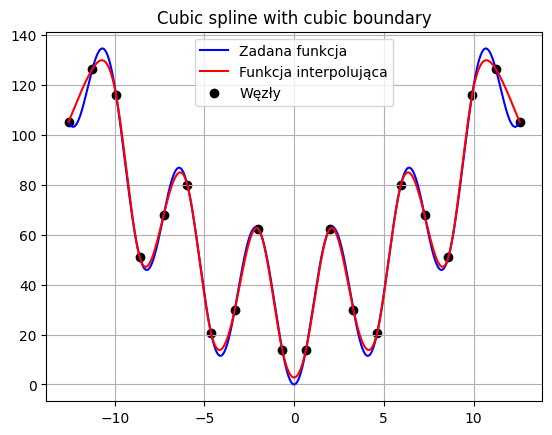

In [27]:
interpolate(Interpolation.CUBIC, get_evenly_distributed, 20, 1000)

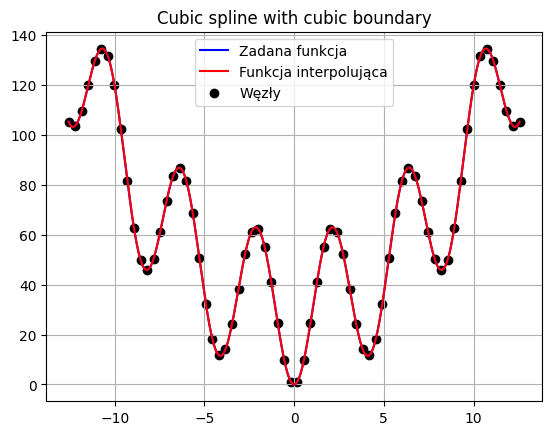

In [28]:
interpolate(Interpolation.CUBIC, get_evenly_distributed, 70, 1000)

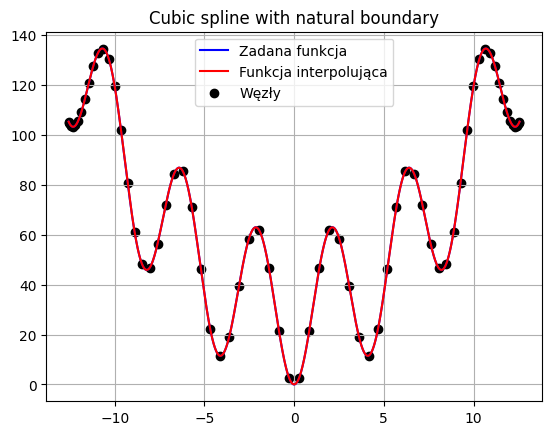

In [29]:
interpolate(Interpolation.CUBIC_NATURAL, get_chebyshev_nodes, 70, 1000)

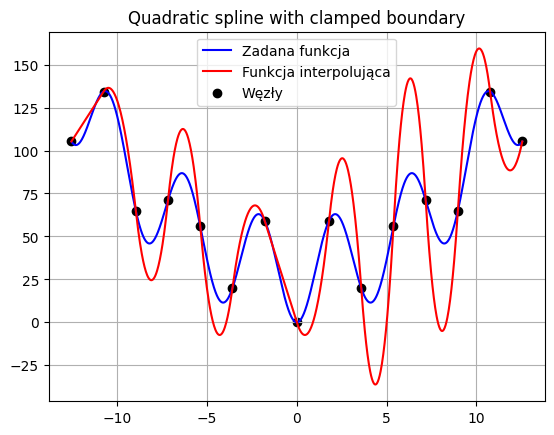

In [35]:
interpolate(Interpolation.QUADRATIC_CLAMPED, get_evenly_distributed, 15, 1000)

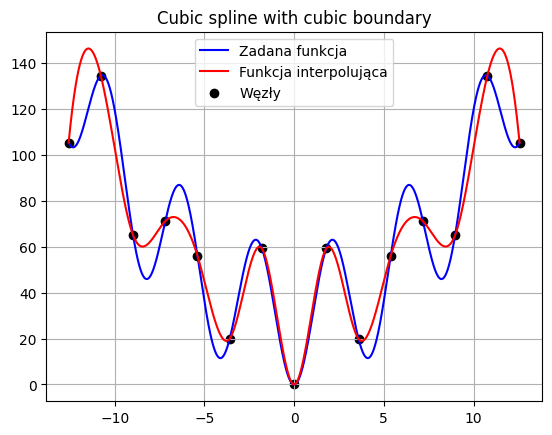

In [36]:
interpolate(Interpolation.CUBIC, get_evenly_distributed, 15, 1000)

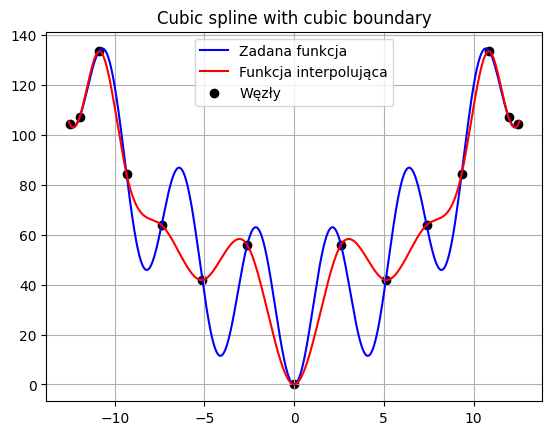

In [37]:
interpolate(Interpolation.CUBIC, get_chebyshev_nodes, 15, 1000)